# Feed Forward Neural Network

> #  First Step : Loading Data

In [ ]:
import torch
from torch.utils.data import Dataset,DataLoader
import numpy as np
from torchvision.transforms import ToTensor

class MusicDataset(Dataset):

    def __init__(self,default_path,to_set,type,labels_dict,transform=None,target_trans = None):

        whole_path = default_path + to_set + type
        to_data = whole_path + '/X.npy'
        to_labels = whole_path + '/labels.npy'
        self.data = np.load(to_data)
        labels = np.load(to_labels)
        self.labels = []
        #convert strings to ints
        for label in labels :
          self.labels.append(labels_dict[label])
        self.transform = transform
        self.target_transform = target_trans

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        music =  self.data[idx]
        label = self.labels[idx]
        if self.transform:
          music = self.transform(music)
        if self.target_transform:
          label = self.target_transform(label)
        sample = {'music': music , 'label': label}
        return sample

In [ ]:
from google.colab import drive

import torch.nn as nn
import torch.nn.functional as F

drive.mount('/content/drive/')

labels_to_int = {"blues" : 0, "classical" : 1 , "hiphop" : 2 , "rock_metal_hardrock" : 3}
int_to_labels = {0 : "blues", 1 :"classical"  , 2 :"hiphop"  , 3 :"rock_metal_hardrock" }

train_set = MusicDataset(default_path = '/content/drive/MyDrive/music_genre_data_di/', to_set = 'train' , type = '/mfccs',labels_dict = labels_to_int,transform=torch.tensor,target_trans = torch.tensor )
val_set = MusicDataset(default_path = '/content/drive/MyDrive/music_genre_data_di/', to_set = 'val' ,type = '/mfccs', labels_dict = labels_to_int,transform=torch.tensor,target_trans = torch.tensor )
test_set = MusicDataset(default_path = '/content/drive/MyDrive/music_genre_data_di/', to_set = 'test' ,type = '/mfccs', labels_dict = labels_to_int,transform=torch.tensor,target_trans = torch.tensor )

#we use batches exclusively in training set since they are only needed to know how many samples we have to process until we change model's parameters and therefore aren't needed in testing and validation
#according to: https://ai.stackexchange.com/questions/10281/what-is-the-difference-between-validation-percentage-and-batch-size

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=800, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1376)

Mounted at /content/drive/


> # Second Step : Defining Fully Connected Neural Network

In [ ]:
class FNN(nn.Module):
  def __init__(self,device):
    super(FNN, self).__init__()           # call the constructor of super
    self.input_layer = nn.Linear(26,128)
    self.hidden_layer = nn.Linear(128,32)
    self.output_layer = nn.Linear(32,4)
    #choose device, if gpu not available switch to cpu
    if device == 'cpu' or torch.cuda.is_available() == False :
      self.device = torch.device('cpu')
    else :
      self.device = torch.device('cuda')

  def forward(self, x):
    x = F.relu(self.input_layer(x))
    x = F.relu(self.hidden_layer(x))
    return self.output_layer(x)

In [ ]:
fnn = FNN("cpu")
fnn = fnn.to(fnn.device)
print(fnn)

FNN(

  (input_layer): Linear(in_features=26, out_features=128, bias=True)

  (hidden_layer): Linear(in_features=128, out_features=32, bias=True)

  (output_layer): Linear(in_features=32, out_features=4, bias=True)

)


 > # Third Step : Defining training function

In [ ]:
import time

def train_func(epochs,optimizer,loader,loss_func,neural) :

  start = time.time()
  #Iterate through batches for every epoch
  for epoch in range(epochs) :
    #iterating through batches
    for i , sample in enumerate(loader) :
      # set to zero the parameter gradients
      optimizer.zero_grad()
      # computing loss
      #input data and neural network must be in the same device
      music = sample['music'].to(neural.device)
      label = sample['label'].to(neural.device)
      output = neural(music.float())
      error = loss_func(output,label)
      print("Loss in ", i + 1,"th batch for ",epoch, "th epoch is : ",error.item())
      # computing gradients/the direction that fits our objective
      error.backward()
      #optimizing weights/slightly adjusting parameters
      optimizer.step()
  end = time.time()
  print("Training in",neural.device, "took ",end - start," s.")
  return neural

> # Fourth Step : Defining Evaluation Function

In [ ]:
%pip install torchmetrics
from torchmetrics.functional import f1_score
from torchmetrics import ConfusionMatrix

def evaluation(loader,loss_func,neural) :
  neural.eval()
  total_error = 0
  total_correct = 0
  #preventing gradient calculations since we will not be optimizing
  with torch.no_grad():
    #iterating through batches calculating total loss and total correct
    #input data and neural network must be in the same device
    for i , sample in enumerate(loader) :
      music = sample['music'].to(neural.device)
      label = sample['label'].to(neural.device)
      output = neural(music.float())
      total_correct += (output.argmax(1) == label).type(torch.float).sum().item()
      total_error += loss_func(output,label).item()

  avg_error = total_error / len(loader.dataset)
  f1_macro = f1_score(output, label, num_classes=4, average="macro",task = "multiclass")
  accuracy = total_correct / len(loader.dataset) * 100
  conf = ConfusionMatrix(num_classes=4,task = "multiclass").to(neural.device)
  matrix = conf(output.argmax(1), label)

  return avg_error , f1_macro , accuracy , matrix



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 24.8 MB/s eta 0:00:00



















Fifth Step : Training NN

In [ ]:
#get the neural network after training
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fnn.parameters(), lr = 0.002)
fnn = train_func(30,optimizer,train_loader,loss_func,fnn)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.

Loss in  2 th batch for  5 th epoch is :  1.3583321571350098

Loss in  3 th batch for  5 th epoch is :  1.379075288772583

Loss in  4 th batch for  5 th epoch is :  1.350337028503418

Loss in  5 th batch for  5 th epoch is :  1.3817601203918457

Loss in  6 th batch for  5 th epoch is :  1.3278650045394897

Loss in  7 th batch for  5 th epoch is :  1.345461368560791

Loss in  8 th batch for  5 th epoch is :  1.3232529163360596

Loss in  9 th batch for  5 th epoch is :  1.332953691482544

Loss in  10 th batch for  5 th epoch is :  1.3807294368743896

Loss in  11 th batch for  5 th epoch is :  1.3583239316940308

Loss in  12 th batch for  5 th epoch is :  1.3126163482666016

Loss in  13 th batch for  5 th epoch is :  1.359511375427246

Loss in  14 th batch for  5 th epoch is :  1.3272432088851929

Loss in  15 th batch for  5 th epoch is :  1.371140956878662

Loss in  16 th batch for  5 th epoch is :  1.374739170074463

Loss in  17 th

In [ ]:
#evaluate the model on test set
loss , f1 , acc , cf_matr = evaluation(test_loader,loss_func,fnn)
print("Model presents average loss :",loss)
print("Model has f1 macro averaged score :",f1.item())
print("Model has accuracy score :",acc)
print("Model has confusion matrix :\n",cf_matr)

Model presents average loss : 0.0007555882424809212

Model has f1 macro averaged score : 0.5856510996818542

Model has accuracy score : 59.520348837209305

Model has confusion matrix :

 tensor([[103,  48, 105,  68],

        [ 27, 256,  10,   4],

        [ 46,  36, 254,  20],

        [100,  44,  49, 206]])


Sixth Step : Training NN with GPU

In [ ]:
train_set_gpu = MusicDataset(default_path = '/content/drive/MyDrive/music_genre_data_di/', to_set = 'train' , type = '/mfccs',labels_dict = labels_to_int,transform=torch.tensor,target_trans = torch.tensor )
val_set_gpu = MusicDataset(default_path = '/content/drive/MyDrive/music_genre_data_di/', to_set = 'val' ,type = '/mfccs', labels_dict = labels_to_int,transform=torch.tensor,target_trans = torch.tensor )
test_set_gpu = MusicDataset(default_path = '/content/drive/MyDrive/music_genre_data_di/', to_set = 'test' ,type = '/mfccs', labels_dict = labels_to_int,transform=torch.tensor,target_trans = torch.tensor )

#we use batches exclusively in training set since they are only needed to know how many samples we have to process until we change model's parameters
train_loader_gpu = DataLoader(train_set_gpu, batch_size=16, shuffle=True)
val_loader_gpu = DataLoader(val_set_gpu, batch_size=800, shuffle=True)
test_loader_gpu = DataLoader(test_set_gpu, batch_size=1376)

fnn_gpu = FNN('gpu')
fnn_gpu = fnn_gpu.to(fnn_gpu.device)
fnn_gpu = train_func(30,optimizer,train_loader_gpu,loss_func,fnn_gpu)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.

Loss in  2 th batch for  5 th epoch is :  1.7710976600646973

Loss in  3 th batch for  5 th epoch is :  1.5950320959091187

Loss in  4 th batch for  5 th epoch is :  1.471971869468689

Loss in  5 th batch for  5 th epoch is :  1.600594162940979

Loss in  6 th batch for  5 th epoch is :  1.6842105388641357

Loss in  7 th batch for  5 th epoch is :  1.431746006011963

Loss in  8 th batch for  5 th epoch is :  1.5557578802108765

Loss in  9 th batch for  5 th epoch is :  1.7245352268218994

Loss in  10 th batch for  5 th epoch is :  1.7969634532928467

Loss in  11 th batch for  5 th epoch is :  1.6960419416427612

Loss in  12 th batch for  5 th epoch is :  1.3445814847946167

Loss in  13 th batch for  5 th epoch is :  1.4701869487762451

Loss in  14 th batch for  5 th epoch is :  1.441697597503662

Loss in  15 th batch for  5 th epoch is :  1.2671313285827637

Loss in  16 th batch for  5 th epoch is :  1.702003002166748

Loss in  17 

# We notice that training in GPU takes slightly longer than CPU even though it is supposed to be faster since it parallelizes execution in different cores. That's probably because the model is quite simple and small and therefore the overhead of invoking GPU kernels, and copying data to and from GPU, is very high whereas CPU has higher frequency so it's faster.

> # Seventh Step : Model Selection

In [ ]:
#We do validation in every single epoch so it has to be combined in the training function to evaluate the efficiency of current parameters

def train_and_val(epochs,optimizer,train_loader,val_loader,loss_func,neural) :

  best_score = -1
  #Iterate through batches for every epoch
  for epoch in range(epochs) :
    #iterating through batches
    for i , sample in enumerate(train_loader) :
      # set to zero the parameter gradients
      optimizer.zero_grad()
      # computing loss
      #input data and neural network must be in the same device
      music = sample['music'].to(neural.device)
      label = sample['label'].to(neural.device)
      output = neural(music.float())
      error = loss_func(output,label)
      # computing gradients/the direction that fits our objective
      error.backward()
      #optimizing weights/slightly adjusting parameters
      optimizer.step()
    #compute validation scores for each epoch
    loss , f1 , acc , cf_matr = evaluation(val_loader,loss_func,neural)

    if f1.item() > best_score :
      wanted = neural
      best_score = f1.item()
      best_epoch = epoch

  print("Best model is in epoch :",best_epoch)

  return wanted

In [ ]:
best_model = train_and_val(30,optimizer,train_loader,val_loader,loss_func,fnn)
#evaluate the model on test set
loss , f1 , acc , cf_matr = evaluation(test_loader,loss_func,best_model)
print("Best model presents average loss :",loss)
print("Best model has f1 macro averaged score :",f1.item())
print("Best model has accuracy score :",acc)
print("Best model has confusion matrix :\n",cf_matr)

Best model is in epoch : 28

Best model presents average loss : 0.0006804773800594862

Best model has f1 macro averaged score : 0.594801664352417

Best model has accuracy score : 62.57267441860465

Best model has confusion matrix :

 tensor([[ 57,  15, 119, 133],

        [ 38, 207,  17,  35],

        [ 21,  10, 298,  27],

        [ 32,  15,  53, 299]])


Since 28 epochs is the best outcome, we realize 30 (with 62.5% accuracy) is an unnecessarily big parameter and slightly
overfits the data.

# Convolutional Neural Network

> # First Step : Loading Data

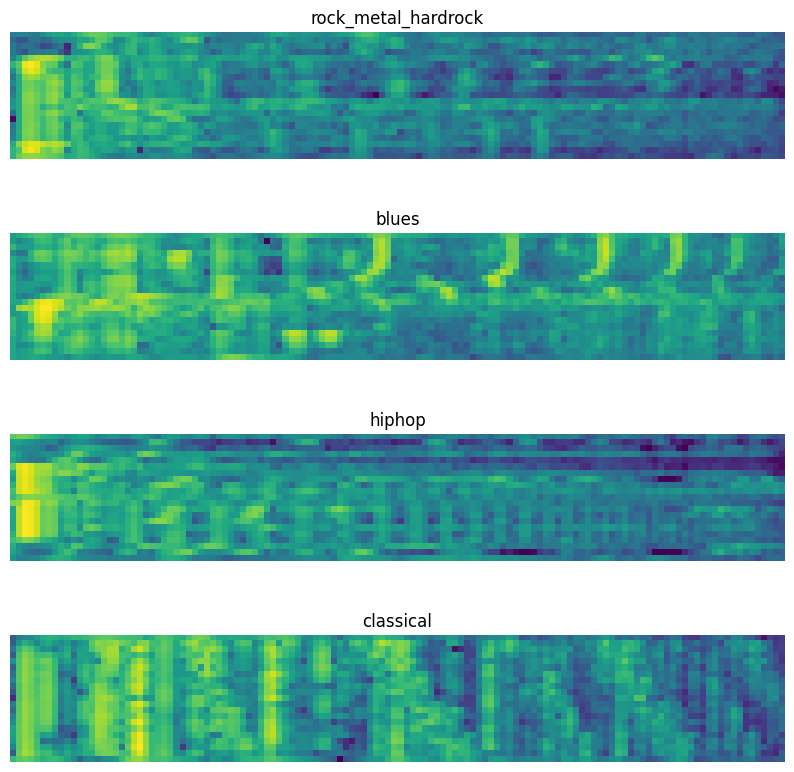

In [ ]:
import matplotlib.pyplot as plt

train_set_mel = MusicDataset(default_path = '/content/drive/MyDrive/music_genre_data_di/', to_set = 'train' , type = '/melgrams',labels_dict = labels_to_int,transform=torch.tensor )
val_set_mel = MusicDataset(default_path = '/content/drive/MyDrive/music_genre_data_di/', to_set = 'val' ,type = '/melgrams', labels_dict = labels_to_int,transform=torch.tensor )
test_set_mel = MusicDataset(default_path = '/content/drive/MyDrive/music_genre_data_di/', to_set = 'test' ,type = '/melgrams', labels_dict = labels_to_int,transform=torch.tensor )

#inspired by the 7th class tutorial : https://colab.research.google.com/drive/1VGkXKiGcJ7npt4NKt9K3LleJfNS270Ak?usp=sharing#scrollTo=G_LY7XRLtkIQ
figure = plt.figure(figsize=(10, 10))
cols, rows = 1, 4
classes = 0
visualized = []
while (classes < 4):
    #pick a random sample from training set
    sample_idx = torch.randint(len(train_set_mel), size=(1,)).item()
    sample = train_set_mel[sample_idx]
    #Make sure we have a melgram for every class
    if(sample['label'] not in visualized) :
      classes+=1
      visualized.append(sample['label'])
      figure.add_subplot(rows, cols, classes)
      plt.title(int_to_labels[sample['label']])
      plt.axis("off")
      plt.imshow(sample['music'].squeeze())
plt.show()

#we use batches exclusively in training set since they are only needed to know how many samples we have to process until we change model's parameters and therefore aren't needed in testing and validation
train_loader_mel = DataLoader(train_set_mel, batch_size=16, shuffle=True)
val_loader_mel = DataLoader(val_set_mel, batch_size=800, shuffle=True)
test_loader_mel = DataLoader(test_set_mel, batch_size=1376)


> # Second Step : Defining Neural Network

In [ ]:
class CNN(nn.Module):

  def __init__(self):
    super(CNN,self).__init__()

    #convolutional layer
    self.conv1 = nn.Conv2d(1,16,5)
    self.conv2 = nn.Conv2d(16,32,5)
    self.conv3= nn.Conv2d(32,64,5)
    self.conv4 = nn.Conv2d(64,128,5)
    #fully connected network's layers
    self.input_layer = nn.Linear(71680,1024)
    self.hidden_1 = nn.Linear(1024,256)
    self.hidden_2 = nn.Linear(256,32)
    self.output = nn.Linear(32,4)

  def forward(self, x):
    #Pass input through convolutional layer
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    # flatten all dimensions except the batch dimension
    x = torch.flatten(x, 1)
    #Pass convolutional layer output through fully connected network
    x = F.relu(self.input_layer(x))
    x = F.relu(self.hidden_1(x))
    x = F.relu(self.hidden_2(x))
    return self.output(x)

#choose device, if gpu not available switch to cpu
if torch.cuda.is_available()  :
  device = torch.device('cuda')
else :
  device = torch.device('cpu')

In [ ]:
cnn = CNN().to(device)
print(cnn)

CNN(

  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))

  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))

  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))

  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))

  (input_layer): Linear(in_features=71680, out_features=1024, bias=True)

  (hidden_1): Linear(in_features=1024, out_features=256, bias=True)

  (hidden_2): Linear(in_features=256, out_features=32, bias=True)

  (output): Linear(in_features=32, out_features=4, bias=True)

)


> # Third Step : Training the Network Redifining the Functions

In [ ]:
def evaluation(loader,loss_func,neural) :
  neural.eval()
  total_error = 0
  total_correct = 0
  #preventing gradient calculations since we will not be optimizing
  with torch.no_grad():
    #iterating through batches calculating total loss and total correct
    #input data and neural network must be in the same device
    for i , sample in enumerate(loader) :
      music = torch.unsqueeze(sample['music'],1)
      music = music.to(device)
      label = sample['label'].to(device)
      output = neural(music)
      total_correct += (output.argmax(1) == label).type(torch.float).sum().item()
      total_error += loss_func(output,label).item()

  avg_error = total_error / len(loader.dataset)
  f1_macro = f1_score(output, label, num_classes=4, average="macro",task = "multiclass")
  accuracy = total_correct / len(loader.dataset) * 100
  conf = ConfusionMatrix(num_classes=4,task = "multiclass").to(device)
  matrix = conf(output.argmax(1), label)
  return avg_error , f1_macro , accuracy , matrix

In [ ]:
#We do validation in every single epoch so it has to be combined in the training function to evaluate the efficiency of current parameters

def train_and_val(epochs,optimizer,train_loader,val_loader,loss_func,neural) :
  neural.train()
  best_score = -1
  #Iterate through batches for every epoch
  for epoch in range(epochs) :
    #iterating through batches
    for i , sample in enumerate(train_loader) :
      # set to zero the parameter gradients
      optimizer.zero_grad()
      # computing loss
      #input data and neural network must be in the same device
      music = torch.unsqueeze(sample['music'],1)
      music = music.to(device)
      label = sample['label'].to(device)
      output = neural(music)
      error = loss_func(output,label)
      # computing gradients/the direction that fits our objective
      error.backward()
      #optimizing weights/slightly adjusting parameters
      optimizer.step()
    #compute validation scores for each epoch
    loss , f1 , acc , cf_matr = evaluation(val_loader,loss_func,neural)
    if f1.item() > best_score :
      wanted = neural
      best_score = f1.item()
      best_epoch = epoch

  return wanted,best_epoch

In [ ]:
#testing the CNN model without pooling and padding
#We opt for Adagrad as optimizer instead of stohastic gradient descent as in previous question because it performs too poorly and won't give as a clear image on the difference in performance
optimizer = torch.optim.Adagrad(cnn.parameters(), lr = 0.02)
start = time.time()
best_model,best_epoch = train_and_val(30,optimizer,train_loader_mel,val_loader_mel,loss_func,cnn)
end = time.time()
print("Training with validation in CNN took ",end-start," s." )
#evaluate the model on test set
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("Best model is in epoch :",best_epoch)
print("Best model presents average loss :",loss)
print("Best model has f1 macro averaged score :",f1.item())
print("Best model has accuracy score :",acc)
print("Best model has confusion matrix :\n",cf_matr)

Training with validation in CNN took  363.2421545982361  s.

Best model is in epoch : 24

Best model presents average loss : 0.003501078763673472

Best model has f1 macro averaged score : 0.42831242084503174

Best model has accuracy score : 44.0406976744186

Best model has confusion matrix :

 tensor([[ 82,  52, 108,  82],

        [101, 145,  17,  34],

        [ 29,  16, 264,  47],

        [ 89,  50, 145, 115]], device='cuda:0')


> # 4th Step : Training & Testing With Pooling & Padding

In [ ]:
#CNN with pooling and padding

class CNN_PP(nn.Module):

  def __init__(self):
    super(CNN_PP,self).__init__()

    #convolutional layer
    self.conv1 = nn.Conv2d(1,16,5,padding=5)
    self.conv2 = nn.Conv2d(16,32,5,padding=5)
    self.conv3= nn.Conv2d(32,64,5,padding=5)
    self.conv4 = nn.Conv2d(64,128,5,padding=5)
    #fully connected network's layers
    self.input_layer = nn.Linear(9984,1024)
    self.hidden_1 = nn.Linear(1024,256)
    self.hidden_2 = nn.Linear(256,32)
    self.output = nn.Linear(32,4)

  def forward(self, x):
    #Pass input through convolutional layer
    x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=2)
    x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=2)
    x = F.max_pool2d(F.relu(self.conv3(x)),kernel_size=2)
    x = F.max_pool2d(F.relu(self.conv4(x)),kernel_size=2)
    # flatten all dimensions except the batch dimension
    x = torch.flatten(x, 1)
    #Pass convolutional layer output through fully connected network
    x = F.relu(self.input_layer(x))
    x = F.relu(self.hidden_1(x))
    x = F.relu(self.hidden_2(x))
    return self.output(x)

In [ ]:
cnn_pp = CNN_PP().to(device)
print(cnn_pp)

CNN_PP(

  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(5, 5))

  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(5, 5))

  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(5, 5))

  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(5, 5))

  (input_layer): Linear(in_features=9984, out_features=1024, bias=True)

  (hidden_1): Linear(in_features=1024, out_features=256, bias=True)

  (hidden_2): Linear(in_features=256, out_features=32, bias=True)

  (output): Linear(in_features=32, out_features=4, bias=True)

)


In [ ]:
#testing the CNN model with pooling and padding
start = time.time()
optimizer = torch.optim.Adagrad(cnn_pp.parameters(), lr = 0.02)
best_model , best_epoch = train_and_val(30,optimizer,train_loader_mel,val_loader_mel,loss_func,cnn_pp)
end = time.time()
print("Training with validation in CNN took ",end-start," s." )
#evaluate the model on test set
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("Best model is in epoch :",best_epoch)
print("Best model presents average loss :",loss)
print("Best model has f1 macro averaged score :",f1.item())
print("Best model has accuracy score :",acc)
print("Best model has confusion matrix :\n",cf_matr)

Training with validation in CNN took  41.71258521080017  s.

Best model is in epoch : 21

Best model presents average loss : 0.0005680017693098201

Best model has f1 macro averaged score : 0.7390831112861633

Best model has accuracy score : 73.69186046511628

Best model has confusion matrix :

 tensor([[181,  10,  75,  58],

        [ 24, 263,   8,   2],

        [ 27,   1, 309,  19],

        [ 75,  11,  52, 261]], device='cuda:0')


# We notice that training with pooling and padding is much faster because we have a smaller number of weights to calculate since with pooling we drop the dimension from patch to patch preserving spatial invariance and we get a considerably big improvement in accuracy (58->71) because pooling keeps only the features with the biggest correlation.Padding helps with accuracy since it ensures that the original borders of the megram matrix are gonna be inspected properly and be scanned well by "moving" them the center of the kernel adding more values  to the original corners of the matrix.

> # 5th Step : Optimization Algorithms

In [ ]:
  #we have already run the algorithm for SGD previously so we skip it here
  Adadelta = CNN_PP().to(device)
  optimizer = torch.optim.Adadelta(Adadelta.parameters(), lr = 0.02)
  best_model , best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, Adadelta)
  loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
  print("Adadelta presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  Adagrad = CNN_PP().to(device)
  optimizer = torch.optim.Adagrad(Adagrad.parameters(), lr = 0.02)
  best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, Adagrad)
  loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
  print("Adagrad presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  Adam = CNN_PP().to(device)
  optimizer = torch.optim.Adam(Adam.parameters(), lr = 0.02)
  best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, Adam)
  loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
  print("Adam presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  AdamW = CNN_PP().to(device)
  optimizer = torch.optim.AdamW(AdamW.parameters(), lr = 0.02)
  best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, AdamW)
  loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
  print("AdamW presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  Adamax = CNN_PP().to(device)
  optimizer = torch.optim.Adamax(Adamax.parameters(), lr = 0.02)
  best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, Adamax)
  loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
  print("Adamax presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  ASGD = CNN_PP().to(device)
  optimizer = torch.optim.ASGD(ASGD.parameters(), lr = 0.02)
  best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, ASGD)
  loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
  print("ASGD presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  NAdam = CNN_PP().to(device)
  optimizer = torch.optim.NAdam(NAdam.parameters(), lr = 0.02)
  best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, NAdam)
  loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
  print("NAdam presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  RAdam = CNN_PP().to(device)
  optimizer = torch.optim.RAdam(RAdam.parameters(), lr = 0.02)
  best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, RAdam)
  loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
  print("RAdam presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  RMSprop = CNN_PP().to(device)
  optimizer = torch.optim.RMSprop(RMSprop.parameters(), lr = 0.02)
  best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, RMSprop)
  loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
  print("RMSprop presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  Rprop = CNN_PP().to(device)
  optimizer = torch.optim.Rprop(Rprop.parameters(), lr = 0.02)
  best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, Rprop)
  loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
  print("Rprop presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

  SGD = CNN_PP().to(device)
  optimizer = torch.optim.SGD(SGD.parameters(), lr = 0.02)
  best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, SGD)
  loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
  print("SGD presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

Adadelta presents accuracy  73.18313953488372  and f1-score  0.7363969087600708  in epoch  27

Adagrad presents accuracy  69.98546511627907  and f1-score  0.7034397721290588  in epoch  17

Adam presents accuracy  25.872093023255815  and f1-score  0.10277136415243149  in epoch  1

AdamW presents accuracy  25.872093023255815  and f1-score  0.10277136415243149  in epoch  0

Adamax presents accuracy  62.06395348837209  and f1-score  0.6256198883056641  in epoch  24

ASGD presents accuracy  68.53197674418605  and f1-score  0.6920038461685181  in epoch  24

NAdam presents accuracy  23.546511627906977  and f1-score  0.09529411792755127  in epoch  0

RAdam presents accuracy  21.584302325581394  and f1-score  0.08876270055770874  in epoch  0

RMSprop presents accuracy  23.546511627906977  and f1-score  0.09529411792755127  in epoch  0

Rprop presents accuracy  51.74418604651163  and f1-score  0.4819764792919159  in epoch  24

SGD presents accuracy  69.62209302325581  and f1-score  0.69419306516

We notice that a poor choice of optimizer reduces accuracy in half and f1-score in almost one tenth and obviously these models tend to have epoch 0 since they get stuck in a local minimum and the parameters remain the same in the rest of the training process.

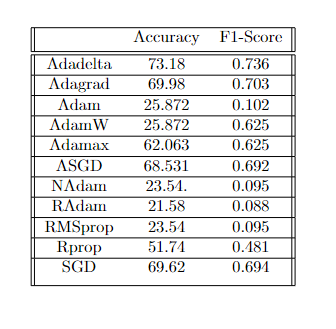

# Improving Performance - 3o Ερώτημα

* Reproducibility

* Redefining loaders , evaluation and training function :

In [ ]:
import random
import os
import tensorflow as tf
import torch.backends.cudnn
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence

%env CUBLAS_WORKSPACE_CONFIG=:4096:8

def set_determenistic_mode():

  #Controlling the source of random number generator
  seed = 12345
  rs = RandomState(MT19937(SeedSequence(seed)))
  torch.manual_seed(seed)
  random.seed(seed)
  np.random.seed(seed)
  torch.cuda.manual_seed_all(seed)
  tf.random.set_seed(seed)
  os.environ['PYTHONHASHSEED']='12345'

  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

def set_epoch(self, epoch):
  self.epoch = epoch
  if self.shuffle:
    self.generator.manual_seed(12345 + self.epoch)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_cpu = torch.Generator(device='cpu')
g_cpu.manual_seed(12345)

set_determenistic_mode()
train_loader_mel = DataLoader(train_set_mel, batch_size=16, shuffle=True,generator=g_cpu,worker_init_fn=seed_worker)
train_loader_mel.shuffle = True

val_loader_mel = DataLoader(val_set_mel, batch_size=800, shuffle=True,generator=g_cpu,worker_init_fn=seed_worker)
val_loader_mel.shuffle = True

test_loader_mel = DataLoader(test_set_mel, batch_size=1376,worker_init_fn=seed_worker)
test_loader_mel.shuffle = False

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [ ]:
def train_and_val_deterministic(epochs,optimizer,train_loader,val_loader,loss_func,neural) :
  neural.train()
  best_score = -1
  #Iterate through batches for every epoch
  for epoch in range(epochs) :
    set_epoch(train_loader,epoch)
    set_epoch(val_loader,epoch)
    #iterating through batches
    for i , sample in enumerate(train_loader) :
      # set to zero the parameter gradients
      optimizer.zero_grad()
      # computing loss
      #input data and neural network must be in the same device
      music = torch.unsqueeze(sample['music'],1)
      music = music.to(device)
      label = sample['label'].to(device)
      output = neural(music.float())
      error = loss_func(output,label)
      # computing gradients/the direction that fits our objective
      error.backward()
      #optimizing weights/slightly adjusting parameters
      optimizer.step()
    #compute validation scores for each epoch
    loss , f1 , acc , cf_matr = evaluation(val_loader,loss_func,neural)

    if f1.item() > best_score :
      wanted = neural
      best_score = f1.item()
      best_epoch = epoch

  return wanted , best_epoch

* Activation Functions :

In [ ]:
#CNN with specified activation function

class CNN_AC(nn.Module):

  def __init__(self,activation):
    super(CNN_AC,self).__init__()

    #convolutional layer
    self.conv1 = nn.Conv2d(1,16,5,padding=5)
    self.conv2 = nn.Conv2d(16,32,5,padding=5)
    self.conv3= nn.Conv2d(32,64,5,padding=5)
    self.conv4 = nn.Conv2d(64,128,5,padding=5)
    #fully connected network's layers
    self.input_layer = nn.Linear(9984,1024)
    self.hidden_1 = nn.Linear(1024,256)
    self.hidden_2 = nn.Linear(256,32)
    self.output = nn.Linear(32,4)
    self.activation = activation()

  def forward(self, x):
    #Pass input through convolutional layer
    x = F.max_pool2d(self.activation(self.conv1(x)),kernel_size=2)
    x = F.max_pool2d(self.activation(self.conv2(x)),kernel_size=2)
    x = F.max_pool2d(self.activation(self.conv3(x)),kernel_size=2)
    x = F.max_pool2d(self.activation(self.conv4(x)),kernel_size=2)
    # flatten all dimensions except the batch dimension
    x = torch.flatten(x, 1)
    #Pass convolutional layer output through fully connected network
    x = self.activation(self.input_layer(x))
    x = self.activation(self.hidden_1(x))
    x = self.activation(self.hidden_2(x))
    return self.output(x)

In [ ]:
#passing each activation function in the cnn class
ELU = CNN_AC(nn.ELU).to(device)
optimizer = torch.optim.SGD(ELU.parameters(), lr = 0.02) #using SGD because so as to wait less for results
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, ELU)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("ELU presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

Hardshrink = CNN_AC(nn.Hardshrink).to(device)
optimizer = torch.optim.SGD(Hardshrink.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, Hardshrink)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("Hardshrink presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

Hardsigmoid = CNN_AC(nn.Hardsigmoid).to(device)
optimizer = torch.optim.SGD(Hardsigmoid.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, Hardsigmoid)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("Hardsigmoid presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

Hardtanh = CNN_AC(nn.Hardtanh).to(device)
optimizer = torch.optim.SGD(Hardtanh.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, Hardtanh)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("Hardtanh presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

Hardswish = CNN_AC(nn.Hardswish).to(device)
optimizer = torch.optim.SGD(Hardswish.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, Hardswish)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("Hardswish presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

LeakyReLU = CNN_AC(nn.LeakyReLU).to(device)
optimizer = torch.optim.SGD(LeakyReLU.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, LeakyReLU)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("LeakyReLU presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

LogSigmoid = CNN_AC(nn.LogSigmoid).to(device)
optimizer = torch.optim.SGD(LogSigmoid.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, LogSigmoid)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("LogSigmoid presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

PReLU = CNN_AC(nn.PReLU).to(device)
optimizer = torch.optim.SGD(PReLU.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, PReLU)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("PReLU presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

ReLU = CNN_AC(nn.ReLU).to(device)
optimizer = torch.optim.SGD(ReLU.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, ReLU)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("ReLU presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

ReLU6 = CNN_AC(nn.ReLU6).to(device)
optimizer = torch.optim.SGD(ReLU6.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, ReLU6)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("ReLU6 presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

RReLU = CNN_AC(nn.RReLU).to(device)
optimizer = torch.optim.SGD(RReLU.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, RReLU)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("RReLU presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

SELU = CNN_AC(nn.SELU).to(device)
optimizer = torch.optim.SGD(SELU.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, SELU)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("SELU presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

CELU = CNN_AC(nn.CELU).to(device)
optimizer = torch.optim.SGD(CELU.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, CELU)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("CELU presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

GELU = CNN_AC(nn.GELU).to(device)
optimizer = torch.optim.SGD(GELU.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, GELU)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("GELU presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

Sigmoid = CNN_AC(nn.Sigmoid).to(device)
optimizer = torch.optim.SGD(Sigmoid.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, Sigmoid)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("Sigmoid presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

SiLU = CNN_AC(nn.SiLU).to(device)
optimizer = torch.optim.SGD(SiLU.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, SiLU)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("SiLU presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

Mish = CNN_AC(nn.Mish).to(device)
optimizer = torch.optim.SGD(Mish.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, Mish)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("Mish presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

Softplus = CNN_AC(nn.Softplus).to(device)
optimizer = torch.optim.SGD(Softplus.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, Softplus)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("Softplus presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

Softshrink = CNN_AC(nn.Softshrink).to(device)
optimizer = torch.optim.SGD(Softshrink.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, Softshrink)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("Softshrink presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

Softsign = CNN_AC(nn.Softsign).to(device)
optimizer = torch.optim.SGD(Softsign.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, Softsign)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("Softsign presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

Tanh = CNN_AC(nn.Tanh).to(device)
optimizer = torch.optim.SGD(Tanh.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, Tanh)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("Tanh presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

Tanhshrink = CNN_AC(nn.Tanhshrink).to(device)
optimizer = torch.optim.SGD(Tanhshrink.parameters(), lr = 0.02)
best_model, best_epoch = train_and_val(30, optimizer, train_loader_mel, val_loader_mel, loss_func, Tanhshrink)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("Tanhshrink presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

ELU presents accuracy  72.31104651162791  and f1-score  0.7248049974441528  in epoch  15

Hardshrink presents accuracy  23.546511627906977  and f1-score  0.09529411792755127  in epoch  12

Hardsigmoid presents accuracy  28.997093023255815  and f1-score  0.11239436268806458  in epoch  0

Hardtanh presents accuracy  60.10174418604651  and f1-score  0.6042216420173645  in epoch  15

Hardswish presents accuracy  72.4563953488372  and f1-score  0.7222194671630859  in epoch  13

LeakyReLU presents accuracy  72.23837209302324  and f1-score  0.7265794277191162  in epoch  29

LogSigmoid presents accuracy  68.8953488372093  and f1-score  0.6896426677703857  in epoch  19

PReLU presents accuracy  70.49418604651163  and f1-score  0.7060810327529907  in epoch  10

ReLU presents accuracy  73.47383720930233  and f1-score  0.7366180419921875  in epoch  19

ReLU6 presents accuracy  67.80523255813954  and f1-score  0.6625897288322449  in epoch  17

RReLU presents accuracy  71.07558139534885  and f1-scor

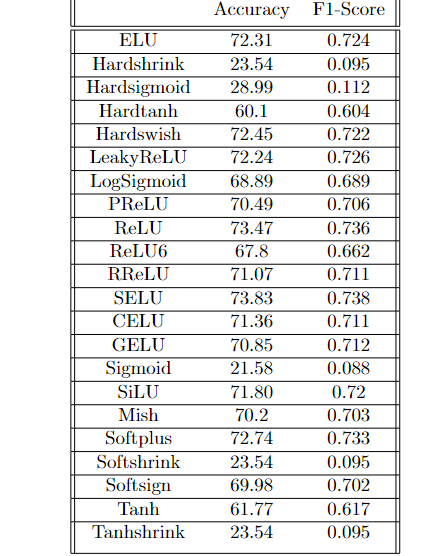

* Learning Rate Scheduler :

In [ ]:
def train_with_scheduler(epochs,optimizer,train_loader,val_loader,loss_func,neural,scheduler) :

  neural.train()
  best_score = -1
  #Iterate through batches for every epoch
  for epoch in range(epochs) :
    #iterating through batches
    for i , sample in enumerate(train_loader) :
      # set to zero the parameter gradients
      optimizer.zero_grad()
      # computing loss
      #input data and neural network must be in the same device
      music = torch.unsqueeze(sample['music'],1)
      music = music.to(device)
      label = sample['label'].to(device)
      output = neural(music.float())
      error = loss_func(output,label)
      # computing gradients/the direction that fits our objective
      error.backward()
      #optimizing weights/slightly adjusting parameters
      optimizer.step()
    #compute validation scores for each epoch
    loss , f1 , acc , cf_matr = evaluation(val_loader,loss_func,neural)
    scheduler.step()

    if f1.item() > best_score :
      wanted = neural
      best_score = f1.item()
      best_epoch = epoch

  return wanted , best_epoch

In [ ]:
cnn_pp = CNN_PP().to(device)
optimizer = torch.optim.SGD(cnn_pp.parameters(), lr = 0.02)

#for demonstration purposes setting verbose to False so as not to litter the output
lmbda = lambda epoch: epoch // 15
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda,verbose = False)
best_model, best_epoch = train_with_scheduler(30, optimizer, train_loader_mel, val_loader_mel, loss_func, cnn_pp,scheduler)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("LambdaLR presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

lmbda = lambda epoch: 0.95
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda,verbose = False)
best_model, best_epoch = train_with_scheduler(30, optimizer, train_loader_mel, val_loader_mel, loss_func, cnn_pp,scheduler)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("MultiplicativeLR presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1,verbose = False)
best_model, best_epoch = train_with_scheduler(30, optimizer, train_loader_mel, val_loader_mel, loss_func, cnn_pp,scheduler)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("StepLR presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1,verbose = False)
best_model, best_epoch = train_with_scheduler(30, optimizer, train_loader_mel, val_loader_mel, loss_func, cnn_pp,scheduler)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("MultiStepLR presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=0.5, total_iters=4,verbose = False)
best_model, best_epoch = train_with_scheduler(30, optimizer, train_loader_mel, val_loader_mel, loss_func, cnn_pp,scheduler)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("ConstantLR presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.5, total_iters=4,verbose = False)
best_model, best_epoch = train_with_scheduler(30, optimizer, train_loader_mel, val_loader_mel, loss_func, cnn_pp,scheduler)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("LinearLR presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.86, verbose=False)
best_model, best_epoch = train_with_scheduler(30, optimizer, train_loader_mel, val_loader_mel, loss_func, cnn_pp,scheduler)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("ExponentialLR presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=4, power=1.0 , verbose=False)
best_model, best_epoch = train_with_scheduler(30, optimizer, train_loader_mel, val_loader_mel, loss_func, cnn_pp,scheduler)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("PolynomialLR presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 5, verbose=False)
best_model, best_epoch = train_with_scheduler(30, optimizer, train_loader_mel, val_loader_mel, loss_func, cnn_pp,scheduler)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("CosineAnnealingWarmRestarts presents accuracy ",acc," and f1-score ",f1.item()," in epoch ",best_epoch)

LambdaLR presents accuracy  65.98837209302324  and f1-score  0.6657875776290894  in epoch  27

MultiplicativeLR presents accuracy  70.78488372093024  and f1-score  0.7105312347412109  in epoch  14

StepLR presents accuracy  70.63953488372093  and f1-score  0.7092430591583252  in epoch  5

MultiStepLR presents accuracy  70.71220930232558  and f1-score  0.7098843455314636  in epoch  0

ConstantLR presents accuracy  70.71220930232558  and f1-score  0.7098843455314636  in epoch  0

LinearLR presents accuracy  70.71220930232558  and f1-score  0.7098843455314636  in epoch  0

ExponentialLR presents accuracy  70.71220930232558  and f1-score  0.7098843455314636  in epoch  0

PolynomialLR presents accuracy  70.71220930232558  and f1-score  0.7098843455314636  in epoch  0

CosineAnnealingWarmRestarts presents accuracy  70.63953488372093  and f1-score  0.7096027731895447  in epoch  0


We notice that the impact of learning rates in accuracy is really small.

> # Batch Normalization :

In [ ]:
#CNN with batch normalization

class CNN_BATCH(nn.Module):

  def __init__(self):
    super(CNN_BATCH,self).__init__()

    #batching functions , one for each input layer
    self.batch1 = nn.BatchNorm2d(1)
    self.batch2 = nn.BatchNorm2d(16)
    self.batch3 = nn.BatchNorm2d(32)
    self.batch4 = nn.BatchNorm2d(64)

    #convolutional layers with batching
    self.conv1 = nn.Conv2d(1,16,5,padding=5)
    self.conv2 = nn.Conv2d(16,32,5,padding=5)
    self.conv3= nn.Conv2d(32,64,5,padding=5)
    self.conv4 = nn.Conv2d(64,128,5,padding=5)

    #fully connected network's layers
    self.input_layer = nn.Linear(9984,1024)
    self.hidden_1 = nn.Linear(1024,256)
    self.hidden_2 = nn.Linear(256,32)
    self.output = nn.Linear(32,4)

  def forward(self, x):

    #Pass input through convolutional layer
    #We apply batching in the input layers as it has way better performance compared to adding them in convolutional layers

    x = F.max_pool2d(F.relu(self.conv1(self.batch1(x))),kernel_size=2)

    x = F.max_pool2d(F.relu(self.conv2(self.batch2(x))),kernel_size=2)

    x = F.max_pool2d(F.relu(self.conv3(self.batch3(x))),kernel_size=2)

    x = F.max_pool2d(F.relu(self.conv4(self.batch4(x))),kernel_size=2)

    # flatten all dimensions except the batch dimension
    x = torch.flatten(x, 1)

    #Pass convolutional layer output through fully connected netwo
    x = F.relu(self.input_layer(x))
    x = F.relu(self.hidden_1(x))
    x = F.relu(self.hidden_2(x))
    return self.output(x)

In [ ]:
#evaluate the model with batch on test set
cnn_batch = CNN_BATCH().to(device)
optimizer = torch.optim.Adagrad(cnn_batch.parameters(), lr = 0.02)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.5, total_iters=4)
best_model , best_epoch = train_with_scheduler(30, optimizer, train_loader_mel, val_loader_mel, loss_func, cnn_batch,scheduler)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("Model with batch is in epoch :",best_epoch)
print("Model with batch presents average loss :",loss)
print("Model with batch has f1 macro averaged score :",f1.item())
print("Model with batch has accuracy score :",acc)
print("Model with batch has confusion matrix :\n",cf_matr)

#evaluate the model on test set without batch
cnn = CNN_PP().to(device)
optimizer = torch.optim.Adagrad(cnn.parameters(), lr = 0.02)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10)
best_model , best_epoch = train_with_scheduler(30, optimizer, train_loader_mel, val_loader_mel, loss_func, cnn,scheduler)
loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
print("Model without batch is in epoch :",best_epoch)
print("Model without batch presents average loss :",loss)
print("Model without batch has f1 macro averaged score :",f1.item())
print("Model without batch has accuracy score :",acc)
print("Model without batch has confusion matrix :\n",cf_matr)

Model with batch is in epoch : 9

Model with batch presents average loss : 0.0012625526030396307

Model with batch has f1 macro averaged score : 0.7851104736328125

Model with batch has accuracy score : 78.19767441860465

Model with batch has confusion matrix :

 tensor([[202,  14,  23,  85],

        [ 10, 283,   3,   1],

        [ 22,   2, 304,  28],

        [ 73,  15,  24, 287]], device='cuda:0')

Model without batch is in epoch : 9

Model without batch presents average loss : 0.0004980493077011996

Model without batch has f1 macro averaged score : 0.753259539604187

Model without batch has accuracy score : 74.92732558139535

Model without batch has confusion matrix :

 tensor([[194,  17,  43,  70],

        [ 12, 281,   1,   3],

        [ 50,   2, 288,  16],

        [ 83,  11,  37, 268]], device='cuda:0')


> # Regularization :

I. Weight Decay in Optimizer

In [ ]:
#trains CNN with batch normalization in epochs epochs with scheduler LinearLR for weight decay wd and optimizer Adagrad
def test_weight_decay(wd , epochs) :

  cnn_batch = CNN_BATCH().to(device)
  optimizer = torch.optim.Adagrad(cnn_batch.parameters(), lr = 0.02 , weight_decay= wd)
  scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.5, total_iters=4)
  best_model , best_epoch = train_with_scheduler(epochs, optimizer, train_loader_mel, val_loader_mel, loss_func, cnn_batch,scheduler)
  loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
  print("Model without dropout and  weight decay =", wd," is in epoch :",best_epoch)
  print("Model without dropout and  weight decay = ", wd,"presents average loss for",epochs,"epochs :",loss)
  print("Model without dropout and  weight decay =", wd," has f1 macro averaged score for",epochs,"epochs :",f1.item())
  print("Model without dropout and  weight decay = ", wd," has accuracy score for",epochs,"epochs :",acc)
  print("Model without dropout and  weight decay = ", wd," has confusion matrix for",epochs,"epochs :\n",cf_matr)

In [ ]:
#Weight Decay is typically between 0 and 0.1 , source : https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/
#We experiment with the values 0.01,0.001 and 0.1
test_weight_decay(0.01,30)
test_weight_decay(0.001,30)
test_weight_decay(0.1,30)
test_weight_decay(0.01,60)
test_weight_decay(0.001,60)
test_weight_decay(0.1,60)

Model without dropout and  weight decay = 0.01  is in epoch : 9

Model without dropout and  weight decay =  0.01 presents average loss for 30 epochs : 0.0004427449041327765

Model without dropout and  weight decay = 0.01  has f1 macro averaged score for 30 epochs : 0.7741755247116089

Model without dropout and  weight decay =  0.01  has accuracy score for 30 epochs : 77.18023255813954

Model without dropout and  weight decay =  0.01  has confusion matrix for 30 epochs :

 tensor([[180,  13,  24, 107],

        [ 14, 275,   0,   8],

        [ 26,   3, 300,  27],

        [ 65,   7,  20, 307]], device='cuda:0')

Model without dropout and  weight decay = 0.001  is in epoch : 9

Model without dropout and  weight decay =  0.001 presents average loss for 30 epochs : 0.0009526963843855747

Model without dropout and  weight decay = 0.001  has f1 macro averaged score for 30 epochs : 0.7644637823104858

Model without dropout and  weight decay =  0.001  has accuracy score for 30 epochs : 76.3808

> # II. Dropout In Linear Layers

In [ ]:
#CNN with batch normalization and dropout

class CNN_DROP(nn.Module):

  def __init__(self , prob):
    super(CNN_DROP ,self).__init__()

    #batching functions , one for each input layer
    self.batch1 = nn.BatchNorm2d(1)
    self.batch2 = nn.BatchNorm2d(16)
    self.batch3 = nn.BatchNorm2d(32)
    self.batch4 = nn.BatchNorm2d(64)

    #convolutional layers with batching
    self.conv1 = nn.Conv2d(1,16,5,padding=5)
    self.conv2 = nn.Conv2d(16,32,5,padding=5)
    self.conv3= nn.Conv2d(32,64,5,padding=5)
    self.conv4 = nn.Conv2d(64,128,5,padding=5)

    #fully connected network's layers
    self.input_layer = nn.Linear(9984,1024)
    self.hidden_1 = nn.Linear(1024,256)
    self.hidden_2 = nn.Linear(256,32)
    self.output = nn.Linear(32,4)

    #dropout function
    self.dropout = nn.Dropout(prob)

  def forward(self, x):

    #Pass input through convolutional layer
    #We apply batching in the input layers as it has way better performance compared to adding them in convolutional layers

    x = F.max_pool2d(F.relu(self.conv1(self.batch1(x))),kernel_size=2)

    x = F.max_pool2d(F.relu(self.conv2(self.batch2(x))),kernel_size=2)

    x = F.max_pool2d(F.relu(self.conv3(self.batch3(x))),kernel_size=2)

    x = F.max_pool2d(F.relu(self.conv4(self.batch4(x))),kernel_size=2)

    # flatten all dimensions except the batch dimension
    x = torch.flatten(x, 1)

    #Pass convolutional layer output through fully connected netwo
    x = F.relu(self.input_layer(x))
    x = self.dropout(x)
    x = F.relu(self.hidden_1(x))
    x = self.dropout(x)
    x = F.relu(self.hidden_2(x))
    x = self.dropout(x)

    return self.output(x)


In [ ]:
#trains CNN with batch normalization and dropout with probability prob in epochs epochs with scheduler LinearLR and optimizer Adagrad

def test_drop(prob,epochs) :
  cnn_drop = CNN_DROP(prob).to(device)
  optimizer = torch.optim.Adagrad(cnn_drop.parameters(), lr = 0.02)
  scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.5, total_iters=4)
  best_model , best_epoch = train_with_scheduler(30, optimizer, train_loader_mel, val_loader_mel, loss_func, cnn_drop,scheduler)
  loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
  print("Model with dropout = ",prob," and  weight decay = 0 is in epoch :",best_epoch)
  print("Model with dropout = ",prob," and  weight decay = 0 presents average loss for",epochs," epochs:",loss)
  print("Model with dropout = ",prob," and  weight decay = 0 has f1 macro averaged score for ",epochs," epochs:",f1.item())
  print("Model with dropout = ",prob," and  weight decay = 0 has accuracy score for ",epochs," epochs:",acc)
  print("Model with dropout = ",prob," and  weight decay = 0 has confusion matrix for ",epochs," epochs:\n",cf_matr)

In [ ]:
#Probability for Dropout should be between 20 to 50% according to https://medium.com/@upendravijay2/how-does-dropout-help-to-avoid-overfitting-in-neural-networks-91b90fd86b20
#We experiment with the values 20,35 and 50
test_drop(0.2,30)
test_drop(0.35,30)
test_drop(0.5,30)
test_drop(0.2,60)
test_drop(0.35,60)
test_drop(0.5,60)

Model with dropout =  0.2  and  weight decay = 0 is in epoch : 12

Model with dropout =  0.2  and  weight decay = 0 presents average loss for 30  epochs: 0.0012422372955222462

Model with dropout =  0.2  and  weight decay = 0 has f1 macro averaged score for  30  epochs: 0.7748563885688782

Model with dropout =  0.2  and  weight decay = 0 has accuracy score for  30  epochs: 77.18023255813954

Model with dropout =  0.2  and  weight decay = 0 has confusion matrix for  30  epochs:

 tensor([[199,  16,  26,  83],

        [  9, 282,   4,   2],

        [ 31,   2, 302,  21],

        [ 77,  13,  30, 279]], device='cuda:0')

Model with dropout =  0.35  and  weight decay = 0 is in epoch : 3

Model with dropout =  0.35  and  weight decay = 0 presents average loss for 30  epochs: 0.0012331386638242145

Model with dropout =  0.35  and  weight decay = 0 has f1 macro averaged score for  30  epochs: 0.793724536895752

Model with dropout =  0.35  and  weight decay = 0 has accuracy score for  30  epoc

> # III.Both

In [ ]:
#trains CNN with batch normalization and dropout with probability prob in epochs epochs with scheduler LinearLR with weight decay wd and optimizer Adagrad

def test_drop_and_weight_decay(prob,wd,epochs) :
  cnn_drop = CNN_DROP(prob).to(device)
  optimizer = torch.optim.Adagrad(cnn_drop.parameters(), lr = 0.02,weight_decay = wd)
  scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.5, total_iters=4)
  best_model , best_epoch = train_with_scheduler(30, optimizer, train_loader_mel, val_loader_mel, loss_func, cnn_drop,scheduler)
  loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
  print("Model with dropout = ",prob," and  weight decay = ",wd," is in epoch :",best_epoch)
  print("Model with dropout = ",prob," and  weight decay = ",wd," presents average loss for",epochs," epochs:",loss)
  print("Model with dropout = ",prob," and  weight decay = ",wd," has f1 macro averaged score for ",epochs," epochs:",f1.item())
  print("Model with dropout = ",prob," and  weight decay = ",wd," has accuracy score for ",epochs," epochs:",acc)
  print("Model with dropout = ",prob," and  weight decay = ",wd," has confusion matrix for ",epochs," epochs:\n",cf_matr)

In [ ]:
#Taking only the best combinations given on performance results
test_drop_and_weight_decay(0.35,0.01,30)
test_drop_and_weight_decay(0.35,0.001,30)
test_drop_and_weight_decay(0.2,0.01,30)
test_drop_and_weight_decay(0.2,0.001,30)

Model with dropout =  0.35  and  weight decay =  0.01  is in epoch : 21

Model with dropout =  0.35  and  weight decay =  0.01  presents average loss for 30  epochs: 0.000514987466293712

Model with dropout =  0.35  and  weight decay =  0.01  has f1 macro averaged score for  30  epochs: 0.763119101524353

Model with dropout =  0.35  and  weight decay =  0.01  has accuracy score for  30  epochs: 76.59883720930233

Model with dropout =  0.35  and  weight decay =  0.01  has confusion matrix for  30  epochs:

 tensor([[156,   4,  49, 115],

        [  9, 275,   2,  11],

        [ 12,   2, 321,  21],

        [ 48,  11,  38, 302]], device='cuda:0')

Model with dropout =  0.35  and  weight decay =  0.001  is in epoch : 2

Model with dropout =  0.35  and  weight decay =  0.001  presents average loss for 30  epochs: 0.0009255546989829041

Model with dropout =  0.35  and  weight decay =  0.001  has f1 macro averaged score for  30  epochs: 0.7851120233535767

Model with dropout =  0.35  and  we

Training Efficiency :

I.Batch Size

In [ ]:
#trains CNN with batch normalization in 30 epochs with scheduler LinearLR and optimizer Adagrad for batch size = size
def test_batch_size(size) :

  cnn = CNN_BATCH().to(device)
  optimizer = torch.optim.Adagrad(cnn.parameters(), lr = 0.02)
  scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.5, total_iters=4)
  start = time.time()
  train_loader_mel = DataLoader(train_set_mel, batch_size = size, shuffle=True)
  val_loader_mel = DataLoader(val_set_mel, batch_size = size, shuffle=True)
  test_loader_mel = DataLoader(test_set_mel, batch_size = size)
  best_model , best_epoch = train_with_scheduler(30, optimizer, train_loader_mel, val_loader_mel, loss_func, cnn,scheduler)
  loss , f1 , acc , cf_matr = evaluation(test_loader_mel,loss_func,best_model)
  end = time.time()

  print("Execution for model with batch size ", size, " took : ",end-start, " s.")
  print("Model with batch size = ",size," is in epoch :",best_epoch)
  print("Model with batch size = ",size," presents average loss ",loss)
  print("Model with batch size = ",size," has f1 macro averaged score ",f1.item())
  print("Model with batch size = ",size," has accuracy score ",acc)
  print("Model with batch size = ",size," has confusion matrix \n",cf_matr)


In [ ]:
test_batch_size(2)
test_batch_size(4)
test_batch_size(8)
test_batch_size(16)
test_batch_size(32)
test_batch_size(64)
test_batch_size(128)

Execution for model with batch size  2  took :  474.1145088672638  s.

Model with batch size =  2  is in epoch : 4

Model with batch size =  2  presents average loss  0.9133320025755708

Model with batch size =  2  has f1 macro averaged score  0.3333333432674408

Model with batch size =  2  has accuracy score  78.48837209302324

Model with batch size =  2  has confusion matrix 

 tensor([[0, 0, 0, 0],

        [0, 0, 0, 0],

        [0, 0, 0, 0],

        [0, 0, 1, 1]], device='cuda:0')

Execution for model with batch size  4  took :  238.6697962284088  s.

Model with batch size =  4  is in epoch : 2

Model with batch size =  4  presents average loss  0.46695498957773535

Model with batch size =  4  has f1 macro averaged score  0.2222222238779068

Model with batch size =  4  has accuracy score  79.06976744186046

Model with batch size =  4  has confusion matrix 

 tensor([[0, 0, 0, 0],

        [0, 0, 0, 0],

        [0, 0, 0, 0],

        [1, 0, 1, 2]], device='cuda:0')

Execution for

**We notice that the smaller the batch size the longer the execution takes , since we are constantly updating the model's parameters which can be really time consuming . However, large batch training methods tend to overfit since they might converge to completely different minima points and get trapped to potential saddle points in the loss landscape.**

> # II.Early Stopping :

In [ ]:
def train_with_stopping(epochs,optimizer,train_loader,val_loader,loss_func,neural,scheduler,patience) :

  neural.train()
  best_score = -1
  continuous = 0
  #Iterate through batches for every epoch
  for epoch in range(epochs) :
    #iterating through batches
    for i , sample in enumerate(train_loader) :
      # set to zero the parameter gradients
      optimizer.zero_grad()
      # computing loss
      #input data and neural network must be in the same device
      music = torch.unsqueeze(sample['music'],1)
      music = music.to(device)
      label = sample['label'].to(device)
      output = neural(music.float())
      error = loss_func(output,label)
      # computing gradients/the direction that fits our objective
      error.backward()
      #optimizing weights/slightly adjusting parameters
      optimizer.step()
    #compute validation scores for each epoch
    loss , f1 , acc , cf_matr = evaluation(val_loader,loss_func,neural)
    scheduler.step()

    if f1.item() > best_score :
      wanted = neural
      best_score = f1.item()
      best_epoch = epoch
      continuous = 0
    else :
      continuous += 1
      if continuous == patience :
          return wanted , best_epoch

  return wanted , best_epoch

In [ ]:
#trains with early stopping for patience = patience a CNN with batch normalization in 30 epochs with scheduler LinearLR and optimizer Adagrad

def test_patience(patience,train_loader,val_loader,test_loader) :

  cnn = CNN_BATCH().to(device)
  optimizer = torch.optim.Adagrad(cnn.parameters(), lr = 0.02)
  scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.5, total_iters=4)
  start = time.time()
  best_model , best_epoch = train_with_stopping(60, optimizer, train_loader, val_loader, loss_func, cnn,scheduler,patience)
  loss , f1 , acc , cf_matr = evaluation(test_loader,loss_func,best_model)
  end = time.time()
  print("\n Execution for model with patience", patience , " took : ",end-start, " s.")
  print("Model with patience", patience," is in epoch :",best_epoch)
  print("Model with patience", patience," presents average loss ",loss)
  print("Model with patience", patience," has f1 macro averaged score ",f1.item())
  print("Model with patience", patience," has accuracy score ",acc)
  print("Model with patience", patience," has confusion matrix \n",cf_matr)

In [ ]:
#redefining loaders with the same batch size as originally
train_loader_mel = DataLoader(train_set_mel, batch_size = 16, shuffle=True)
val_loader_mel = DataLoader(val_set_mel, batch_size = 800, shuffle=True)
test_loader_mel = DataLoader(test_set_mel, batch_size = 1376)

#We test patience of 5,10,15 and 20 epochs given that total training epochs is 60
test_patience(5,train_loader_mel,val_loader_mel,test_loader_mel)
test_patience(10,train_loader_mel,val_loader_mel,test_loader_mel)
test_patience(15,train_loader_mel,val_loader_mel,test_loader_mel)
test_patience(20,train_loader_mel,val_loader_mel,test_loader_mel)



 Execution for model with patience 5  took :  18.937010765075684  s.

Model with patience 5  is in epoch : 4

Model with patience 5  presents average loss  0.0004631777315638786

Model with patience 5  has f1 macro averaged score  0.7713434100151062

Model with patience 5  has accuracy score  77.76162790697676

Model with patience 5  has confusion matrix 

 tensor([[150,  12,  42, 120],

        [  7, 286,   0,   4],

        [ 20,   2, 315,  19],

        [ 40,  11,  29, 319]], device='cuda:0')



 Execution for model with patience 10  took :  41.439220666885376  s.

Model with patience 10  is in epoch : 10

Model with patience 10  presents average loss  0.001012433580187864

Model with patience 10  has f1 macro averaged score  0.7928775548934937

Model with patience 10  has accuracy score  79.06976744186046

Model with patience 10  has confusion matrix 

 tensor([[201,  12,  24,  87],

        [  9, 283,   1,   4],

        [ 21,   2, 308,  25],

        [ 60,  17,  26, 296]], devi

* Inference :

In [ ]:
def inference_func(dataloader , cnn) :

  cnn_output = []
  with torch.no_grad():

    for i, sample in enumerate(dataloader):

      music = torch.unsqueeze(sample['music'],1)
      music = music.to(device)
      label = sample['label'].to(device)
      output = cnn(music.float())
      #pick the index with the highest probability and make the correspondence between the int and the music genre
      cnn_output.append(int_to_labels[output.argmax(1).item()])

  return cnn_output

In [ ]:
!sudo apt-get update
!python3 -m pip install -U yt-dlp
# !python3 -m pip install --upgrade --force-reinstall "git+https://github.com/ytdl-org/youtube-dl.git"
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
!sudo chmod a+rx /usr/local/bin/youtube-dlp

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]

Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease     

Hit:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease     

Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease             

Hit:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease           

Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease     

Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease

Hit:8 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease            

Hit:9 http://archive.ubuntu.com/ubuntu focal InRelease

Hit:10 http://archive.ubuntu.com/ubuntu focal-updates InRelease

Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]

Fetched 222 kB in 5s (44.7 kB/s)

Reading package lists... Done







  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Curren

In [ ]:
class ytMelgram(Dataset):

    def __init__(self,actual_genre,labels_dict,transform=None,target_trans = None):

        self.data = np.load('youtube_melgrams.npy')
        self.labels = []
        #convert strings to ints
        for data in self.data :
          self.labels.append(labels_dict[actual_genre])
        self.transform = transform
        self.target_transform = target_trans

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        music =  self.data[idx]
        label = self.labels[idx]
        if self.transform:
          music = self.transform(music)
        if self.target_transform:
          label = self.target_transform(label)
        sample = {'music': music , 'label': label}
        return sample

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive')
import youtube as yt

def predict(URL,genre) :
  yt.youtube_to_melgram(URL)
  test_set = ytMelgram(genre,labels_to_int,torch.tensor)
  #keeping shuffle False to be in term with inference
  test_loader = DataLoader(test_set, batch_size=1 ,shuffle=False )

  #this model had the best performance in metrics
  cnn_drop = CNN_DROP(0.35).to(device)
  optimizer = torch.optim.Adagrad(cnn_drop.parameters(), lr = 0.02)
  scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.5, total_iters=4)
  best_model , best_epoch = train_with_scheduler(30, optimizer, train_loader_mel, val_loader_mel, loss_func, cnn_drop,scheduler)

  model_labels = inference_func(test_loader,best_model)
  plt.plot(model_labels)
  loss , f1 , acc , cf_matr = evaluation(test_loader,loss_func,cnn)
  print("Model has f1 macro averaged score ",f1.item())
  print("Model has accuracy score ",acc)


[youtube] Extracting URL: https://www.youtube.com/watch?v=9E6b3swbnWg

[youtube] 9E6b3swbnWg: Downloading webpage

[youtube] 9E6b3swbnWg: Downloading ios player API JSON

[youtube] 9E6b3swbnWg: Downloading android player API JSON

[youtube] 9E6b3swbnWg: Downloading m3u8 information

[info] 9E6b3swbnWg: Downloading 1 format(s): 251

[download] Destination: temp.webm

[download] 100% of    4.85MiB in 00:00:00 at 80.22MiB/s

[ExtractAudio] Destination: temp.wav

Deleting original file temp.webm (pass -k to keep)

Model has f1 macro averaged score  1.0

Model has accuracy score  98.88888888888889


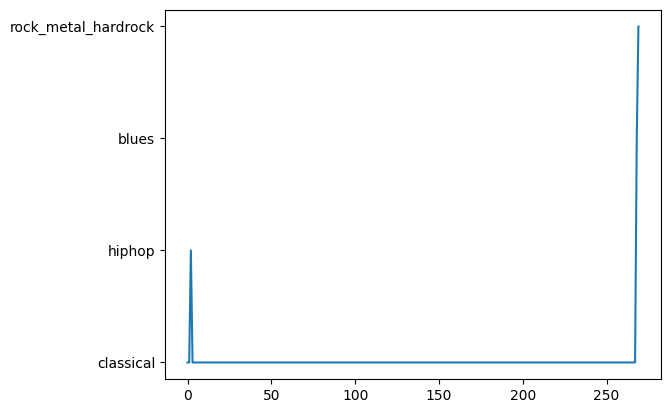

In [ ]:
!yt-dlp -x --audio-format wav --audio-quality 0 --output temp.wav --postprocessor-args "-ar 8000 -ac 1" https://www.youtube.com/watch?v=9E6b3swbnWg&ab_channel=andrearomano
predict("https://www.youtube.com/watch?v=9E6b3swbnWg&ab_channel=andrearomano" , "classical")


[youtube] Extracting URL: https://www.youtube.com/watch?v=EDwb9jOVRtU

[youtube] EDwb9jOVRtU: Downloading webpage

[youtube] EDwb9jOVRtU: Downloading ios player API JSON

[youtube] EDwb9jOVRtU: Downloading android player API JSON

[youtube] EDwb9jOVRtU: Downloading m3u8 information

[info] EDwb9jOVRtU: Downloading 1 format(s): 251

[download] Destination: temp.webm

[download] 100% of    5.14MiB in 00:00:00 at 76.16MiB/s

[ExtractAudio] Destination: temp.wav

Deleting original file temp.webm (pass -k to keep)

Model has f1 macro averaged score  0.0

Model has accuracy score  23.053892215568865


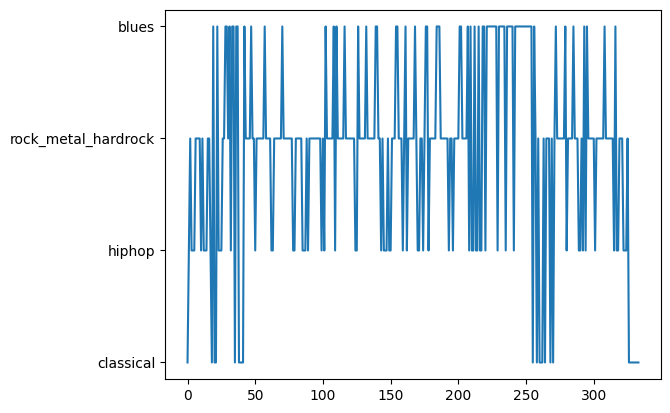

In [ ]:
os.remove("youtube_melgrams.npy")
os.remove("temp.wav")
!yt-dlp -x --audio-format wav --audio-quality 0 --output temp.wav --postprocessor-args "-ar 8000 -ac 1" https://www.youtube.com/watch?v=EDwb9jOVRtU&ab_channel=Madonna
predict("https://www.youtube.com/watch?v=EDwb9jOVRtU&ab_channel=Madonna","hiphop")


[youtube] Extracting URL: https://www.youtube.com/watch?v=OMaycNcPsHI

[youtube] OMaycNcPsHI: Downloading webpage

[youtube] OMaycNcPsHI: Downloading ios player API JSON

[youtube] OMaycNcPsHI: Downloading android player API JSON

[youtube] OMaycNcPsHI: Downloading m3u8 information

[info] OMaycNcPsHI: Downloading 1 format(s): 251

[download] Destination: temp.webm

[download] 100% of    3.32MiB in 00:00:00 at 65.14MiB/s

[ExtractAudio] Destination: temp.wav

Deleting original file temp.webm (pass -k to keep)

Model has f1 macro averaged score  1.0

Model has accuracy score  87.5


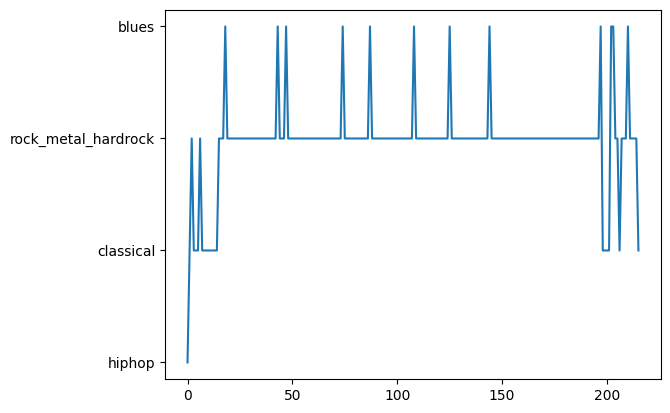

In [ ]:
os.remove("youtube_melgrams.npy")
os.remove("temp.wav")
!yt-dlp -x --audio-format wav --audio-quality 0 --output temp.wav --postprocessor-args "-ar 8000 -ac 1" https://www.youtube.com/watch?v=OMaycNcPsHI&ab_channel=PLACEBO
predict("https://www.youtube.com/watch?v=OMaycNcPsHI&ab_channel=PLACEBO","rock_metal_hardrock")


[youtube] Extracting URL: https://www.youtube.com/watch?v=l45f28PzfCI

[youtube] l45f28PzfCI: Downloading webpage

[youtube] l45f28PzfCI: Downloading ios player API JSON

[youtube] l45f28PzfCI: Downloading android player API JSON

[youtube] l45f28PzfCI: Downloading m3u8 information

[info] l45f28PzfCI: Downloading 1 format(s): 251

[download] Destination: temp.webm

[download] 100% of    5.26MiB in 00:00:00 at 50.21MiB/s

[ExtractAudio] Destination: temp.wav

Deleting original file temp.webm (pass -k to keep)

Model has f1 macro averaged score  0.0

Model has accuracy score  61.0223642172524


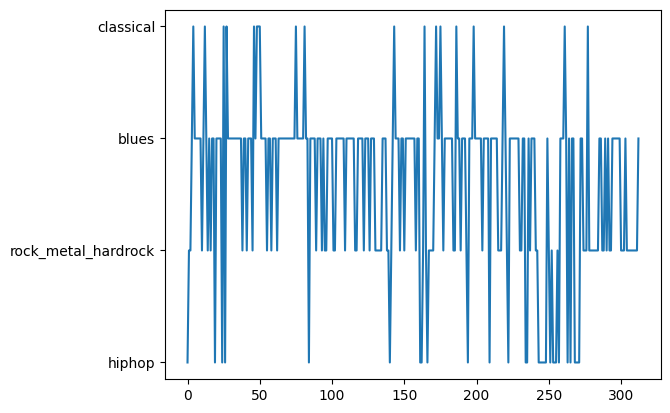

In [ ]:
os.remove("youtube_melgrams.npy")
os.remove("temp.wav")
!yt-dlp -x --audio-format wav --audio-quality 0 --output temp.wav --postprocessor-args "-ar 8000 -ac 1" https://www.youtube.com/watch?v=l45f28PzfCI&ab_channel=Zumramania
predict("https://www.youtube.com/watch?v=l45f28PzfCI&ab_channel=Zumramania","blues")

The model we used gor testing the songs is batch normalization with dropout for 35% in 30 epochs and LinearLr scheduler since it had the best performance out of all the metrics we examined (79.8% on total test set).The accuracy we get on predictions obviously is representative of how "purely" the song belongs to the genre we have classified it. Therefore, the first one has the best accuracy score (almost 100) since it is a dictinctively classical song, the second one belongs to pop normally not in hiphop so we only have around 23%. The third one is easily classified as rock-metal-hardrock even though in certain timelines it could be categorized as other genres as well and the fourth one is a mix of different ones depending on the timespace.